In [1]:
import findspark
findspark.init()

In [2]:
import re
import nltk
from pyspark import SparkConf, SparkContext
from nltk.corpus import stopwords
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF 
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
import pyspark.sql as SQL
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
spark = SparkSession.builder.appName('YelpBusinessReview').getOrCreate()

In [4]:
df = spark.read.format("csv").option("header", "true").option("multiline","true").load("yelp_business.csv") 
df.printSchema()
df.show()

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- address: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- review_count: string (nullable = true)
 |-- is_open: string (nullable = true)
 |-- categories: string (nullable = true)

+--------------------+--------------------+------------------+--------------------+--------------+-------------+-----------+-------------+--------------+------------+------------+-------+--------------------+
|         business_id|                name|      neighborhood|             address|          city|        state|postal_code|     latitude|     longitude|       stars|review_count|is_open|          categories|
+--------------------+--------------------+------------

In [5]:
business_df = df.select("business_id","review_count","stars","categories")
business_df.show()

+--------------------+------------+------------+--------------------+
|         business_id|review_count|       stars|          categories|
+--------------------+------------+------------+--------------------+
|FYWN1wneV18bWNgQj...|         4.0|-111.9785992|                   1|
|He-G7vWjzVUysIKrf...|          11|         3.0|Hair Stylists;Hai...|
|KQPW8lFf1y5BT2Mxi...|         1.5|-112.1153098|                   1|
|8DShNS-LuFqpEWIp0...|         3.0|-111.9647254|                   0|
|PfOCPjBrlQAnz__NX...|         116|         3.5|American (New);Ni...|
|o9eMRCWt5PkpLDE0g...|           5|         4.0| Italian;Restaurants|
|kCoE3jvEtg6UVz5SO...|         4.0|  -115.26846|                   1|
|OD2hnuuTJI9uotcKy...|         1.5|-115.2496601|                   1|
|EsMcGiZaQuG1OOvL9...|          15|         5.0|Coffee & Tea;Ice ...|
|TGWhGNusxyMaA4kQV...|           7|         5.0|Automotive;Auto D...|
|XOSRcvtaKc_Q5H1SA...|           3|         4.5|Breakfast & Brunc...|
|Y0eMNa5C-YU1RQOZf..

In [6]:
li = ["5.0","4.5","4.0","3.5","3.0","2.5","2.0","1.5","1.0"]
business_review = business_df.filter(df.stars.isin(li))
business_review.show()

+--------------------+------------+-----+--------------------+
|         business_id|review_count|stars|          categories|
+--------------------+------------+-----+--------------------+
|He-G7vWjzVUysIKrf...|          11|  3.0|Hair Stylists;Hai...|
|PfOCPjBrlQAnz__NX...|         116|  3.5|American (New);Ni...|
|o9eMRCWt5PkpLDE0g...|           5|  4.0| Italian;Restaurants|
|EsMcGiZaQuG1OOvL9...|          15|  5.0|Coffee & Tea;Ice ...|
|TGWhGNusxyMaA4kQV...|           7|  5.0|Automotive;Auto D...|
|XOSRcvtaKc_Q5H1SA...|           3|  4.5|Breakfast & Brunc...|
|Y0eMNa5C-YU1RQOZf...|          23|  5.0|Local Services;Se...|
|xcgFnd-MwkZeO5G2H...|          38|  4.0|Bakeries;Bagels;Food|
|NmZtoE3v8RdSJEczY...|           5|  2.0|General Dentistry...|
|fNMVV_ZX7CJSDWQGd...|           7|  3.5|Restaurants;Ameri...|
|l09JfMeQ6ynYs5MCJ...|          12|  3.0|Italian;French;Re...|
|b2I2DXtZVnpUMCXp1...|           9|  3.5|Tires;Oil Change ...|
|0FMKDOU8TJT1x87OK...|          65|  5.0|Barbers;Beauty

In [7]:
from pyspark.sql import functions as f
from pyspark.sql.functions import split,col,explode,count
from pyspark.sql.functions import length

#business_review_split = business_review.withColumn('categories_split', (f.split(f.col('categories'), ';')))
#business_review_split.show()

business_split = business_review.withColumn("category_split",split(col("categories"),";").getItem(0))
business_split.show()

+--------------------+------------+-----+--------------------+--------------------+
|         business_id|review_count|stars|          categories|      category_split|
+--------------------+------------+-----+--------------------+--------------------+
|He-G7vWjzVUysIKrf...|          11|  3.0|Hair Stylists;Hai...|       Hair Stylists|
|PfOCPjBrlQAnz__NX...|         116|  3.5|American (New);Ni...|      American (New)|
|o9eMRCWt5PkpLDE0g...|           5|  4.0| Italian;Restaurants|             Italian|
|EsMcGiZaQuG1OOvL9...|          15|  5.0|Coffee & Tea;Ice ...|        Coffee & Tea|
|TGWhGNusxyMaA4kQV...|           7|  5.0|Automotive;Auto D...|          Automotive|
|XOSRcvtaKc_Q5H1SA...|           3|  4.5|Breakfast & Brunc...|  Breakfast & Brunch|
|Y0eMNa5C-YU1RQOZf...|          23|  5.0|Local Services;Se...|      Local Services|
|xcgFnd-MwkZeO5G2H...|          38|  4.0|Bakeries;Bagels;Food|            Bakeries|
|NmZtoE3v8RdSJEczY...|           5|  2.0|General Dentistry...|   General Den

In [8]:
pandasDF = business_split.toPandas()
pandasDF.head()

,business_id,review_count,stars,categories,category_split
0,He-G7vWjzVUysIKrfNbPUQ,11,3.0,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...,Hair Stylists
1,PfOCPjBrlQAnz__NXj9h_w,116,3.5,American (New);Nightlife;Bars;Sandwiches;Ameri...,American (New)
2,o9eMRCWt5PkpLDE0gOPtcQ,5,4.0,Italian;Restaurants,Italian
3,EsMcGiZaQuG1OOvL9iUFug,15,5.0,Coffee & Tea;Ice Cream & Frozen Yogurt;Food,Coffee & Tea
4,TGWhGNusxyMaA4kQVBNeew,7,5.0,Automotive;Auto Detailing,Automotive


In [9]:
#here I am changing the types (reviews counts and stars to integers)
from pyspark.sql.types import IntegerType
business_split = business_split.withColumn("stars", business_split["stars"].cast(IntegerType()))

In [10]:
business_split = business_split.withColumn("review_count", business_split["review_count"].cast(IntegerType()))
business_split.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- stars: integer (nullable = true)
 |-- categories: string (nullable = true)
 |-- category_split: string (nullable = true)



In [11]:
#here I am doing a average star rating and sum of review count by categories
from pyspark.sql import functions as F
from pyspark.sql.functions import desc

business_agg = business_split.groupBy("category_split").agg(F.mean('stars'), F.sum('review_count')).sort(col("sum(review_count)").desc())
business_agg.show()

+--------------------+------------------+-----------------+
|      category_split|        avg(stars)|sum(review_count)|
+--------------------+------------------+-----------------+
|         Restaurants|3.1610435732823383|           665150|
|                Food| 3.406812227074236|           157198|
|           Nightlife|3.2507539853511416|           118823|
|                Bars| 3.259396506087877|           115304|
|American (Traditi...|3.0545004128819158|            90576|
|      American (New)|3.2106598984771573|            82841|
|             Mexican|3.1513377926421406|            79411|
|  Breakfast & Brunch| 3.292056074766355|            66240|
|            Shopping| 3.323824209714726|            61227|
|          Sandwiches| 3.207161125319693|            58721|
|             Italian|3.2652027027027026|            58483|
|Event Planning & ...| 3.441997851772288|            55818|
|               Pizza|3.0590428837787447|            55712|
|Arts & Entertainment| 3.561388653683319

In [12]:
#sorting based on average star ratings - higher star ratings

business_split.groupBy("category_split").agg(F.mean('stars'), F.sum('review_count')).sort(col("avg(stars)").desc()).show()

+--------------------+----------+-----------------+
|      category_split|avg(stars)|sum(review_count)|
+--------------------+----------+-----------------+
|Personal Care Ser...|       5.0|                4|
|     Trailer Dealers|       5.0|                3|
|  Pet Transportation|       5.0|               16|
|Mobility Equipmen...|       5.0|                3|
|  Storefront Clinics|       5.0|                3|
|     Art Restoration|       5.0|               17|
|    Knife Sharpening|       5.0|               34|
|      Dinner Theater|       5.0|                9|
|Chinese Martial Arts|       5.0|               15|
| Digitizing Services|       5.0|                3|
|   Game Truck Rental|       5.0|                4|
| Private Jet Charter|       5.0|                6|
|        Contract Law|       5.0|               12|
|           Skydiving|       5.0|                8|
|             Sailing|       5.0|                3|
|  Concierge Medicine|       5.0|               10|
|Self-defens

In [13]:
#sorting based on average star ratings - lower star ratings
from pyspark.sql.functions import asc
business_split.groupBy("category_split").agg(F.mean('stars'), F.sum('review_count')).sort(col("avg(stars)").asc()).show()
#shows the middle ranked business based on review count
print('middle')
business_middle_rank = business_agg.filter((F.col('avg(stars)') > 3.0) & (f.col('avg(stars)') < 4.0))
business_middle_rank.show()
#shows the highest ranked businesses based on review count
print('high')
business_highest_rank = business_agg.filter((F.col('avg(stars)') > 4.0) & (f.col('avg(stars)') < 5.1))
business_highest_rank.show()
#shows the lowest ranked businesses based on review count
print('low')
business_lowest_rank = business_agg.filter((F.col('avg(stars)') > 0.0) & (f.col('avg(stars)') < 3.0))
business_lowest_rank.show()

+--------------------+------------------+-----------------+
|      category_split|        avg(stars)|sum(review_count)|
+--------------------+------------------+-----------------+
|Health Insurance ...|               1.0|               49|
|     Duty-Free Shops|               1.0|                3|
|     Home Developers|               1.0|                9|
|Television Servic...|              1.64|             1108|
|  Addiction Medicine|1.6666666666666667|               17|
|         Matchmakers|              1.75|               20|
|           Utilities|1.8333333333333333|              152|
|Internet Service ...| 1.853658536585366|              669|
|         Medical Law|               2.0|                3|
|Generator Install...|               2.0|               42|
|       Cardiologists|               2.0|               11|
|        Car Auctions|               2.0|               29|
|   Sleep Specialists|               2.0|                7|
|          Fishmonger|               2.0

In [14]:
pandasDF = business_agg.toPandas()
pandasDF.head()

,category_split,avg(stars),sum(review_count)
0,Restaurants,3.161044,665150
1,Food,3.406812,157198
2,Nightlife,3.250754,118823
3,Bars,3.259397,115304
4,American (Traditional),3.054500,90576


Text(0.5, 1.0, 'Top Category Avg Rating')

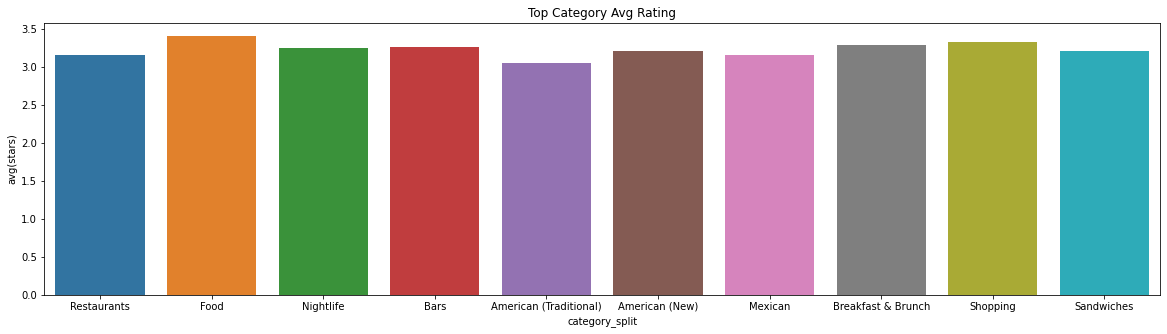

In [15]:
l = pandasDF.nlargest(10, 'sum(review_count)')
f, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot(x = "category_split",y="avg(stars)",data = l, ci = None)
plt.title("Top Category Avg Rating", size=12)

Text(0.5, 1.0, 'Top Category Review')

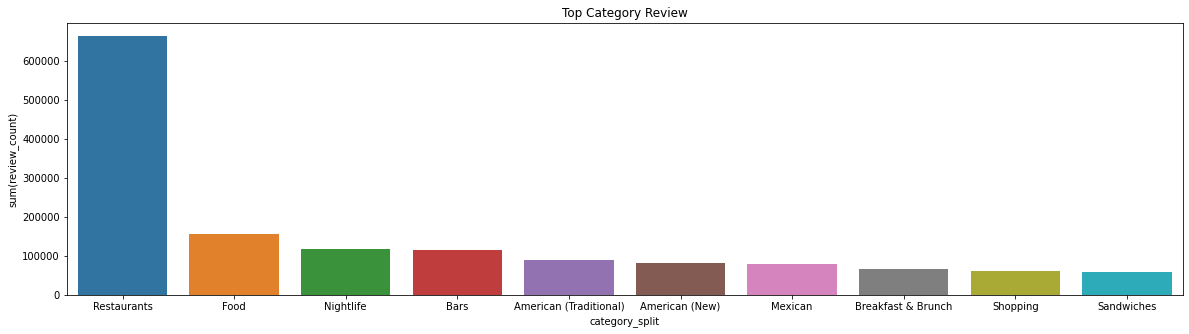

In [16]:
l = pandasDF.nlargest(10, 'sum(review_count)')
f, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot(x = "category_split",y="sum(review_count)",data = l, ci = None)
plt.title("Top Category Review", size=12)